In [32]:
import os

import fire
import pandas as pd
import plot_helpers.plot
import utils.rosbag
import importlib
importlib.reload(plot_helpers.colors)
importlib.reload(plot_helpers.plot)
importlib.reload(utils.rosbag)
from utils.rosbag import create_frenet_converter, get_trackbounds_from_bag, get_topics_in_bag, get_states_from_bag
from plot_helpers.plot import plot_trajectories, setup_grid, finish_fig, add_legend_entry, plot_line, plot_arrow
colors= plot_helpers.colors.get_colors()


In [17]:
START = 1737022526.818121814

TIMES = [
    [15, 23], # trail 1
    [23 , 24.7], # ot 1
    [32, 40], # trail 2
    [40, 43] # ot 2
]

for i, time in enumerate(TIMES):
    TIMES[i] = [time[0] + START, time[1] + START]

NUM_OPP = 2
BAG = "/home/moe/data/multi/multi_opp_test_center_sp2.bag"
YAW_EVERY = 20 

In [18]:
def get_data(bag, times):
    data = []
    ego_data = get_states_from_bag(bag, odom_topic="/car_state/odom")
    opp_data = []

    for i in range(NUM_OPP):
        opp_data.append(get_states_from_bag(bag, odom_topic=f"/opp{i + 1}/car_state/odom"))

    
    for i, time in enumerate(times):
        new_data = pd.DataFrame()
        ego_data_slice = ego_data[(ego_data["time"] > time[0]) & (ego_data["time"] < time[1])]        
        new_data["x_ego"] = ego_data_slice["position_x"]
        new_data["y_ego"] = ego_data_slice["position_y"]
        new_data["yaw_ego"] = ego_data_slice["yaw"]
        
        for j in range(NUM_OPP):
            opp_data_slice = opp_data[j][(opp_data[j]["time"] > time[0]) & (opp_data[j]["time"] < time[1])]
            new_data[f"x_opp{j}"] = opp_data_slice["position_x"]
            new_data[f"y_opp{j}"] = opp_data_slice["position_y"]
            new_data[f"yaw_opp{j}"] = opp_data_slice["yaw"]
        data.append(new_data)
    return data

In [19]:
data = get_data(BAG, TIMES)
fc  = create_frenet_converter(BAG)
boundary_ext, boundary_int = get_trackbounds_from_bag(BAG)

Getting states |████████████████████████████████████████| 5084/5084 [100%] in 0.2s (22394.41/s) 
Getting states |████████████████████████████████████████| 5084/5084 [100%] in 0.2s (22934.50/s) 
Getting states |████████████████████████████████████████| 5081/5081 [100%] in 0.2s (22701.59/s) 
Trackbounds |████████████████████████████████████████| 1297/1297 [100%] in 0.1s (18627.57/s) 


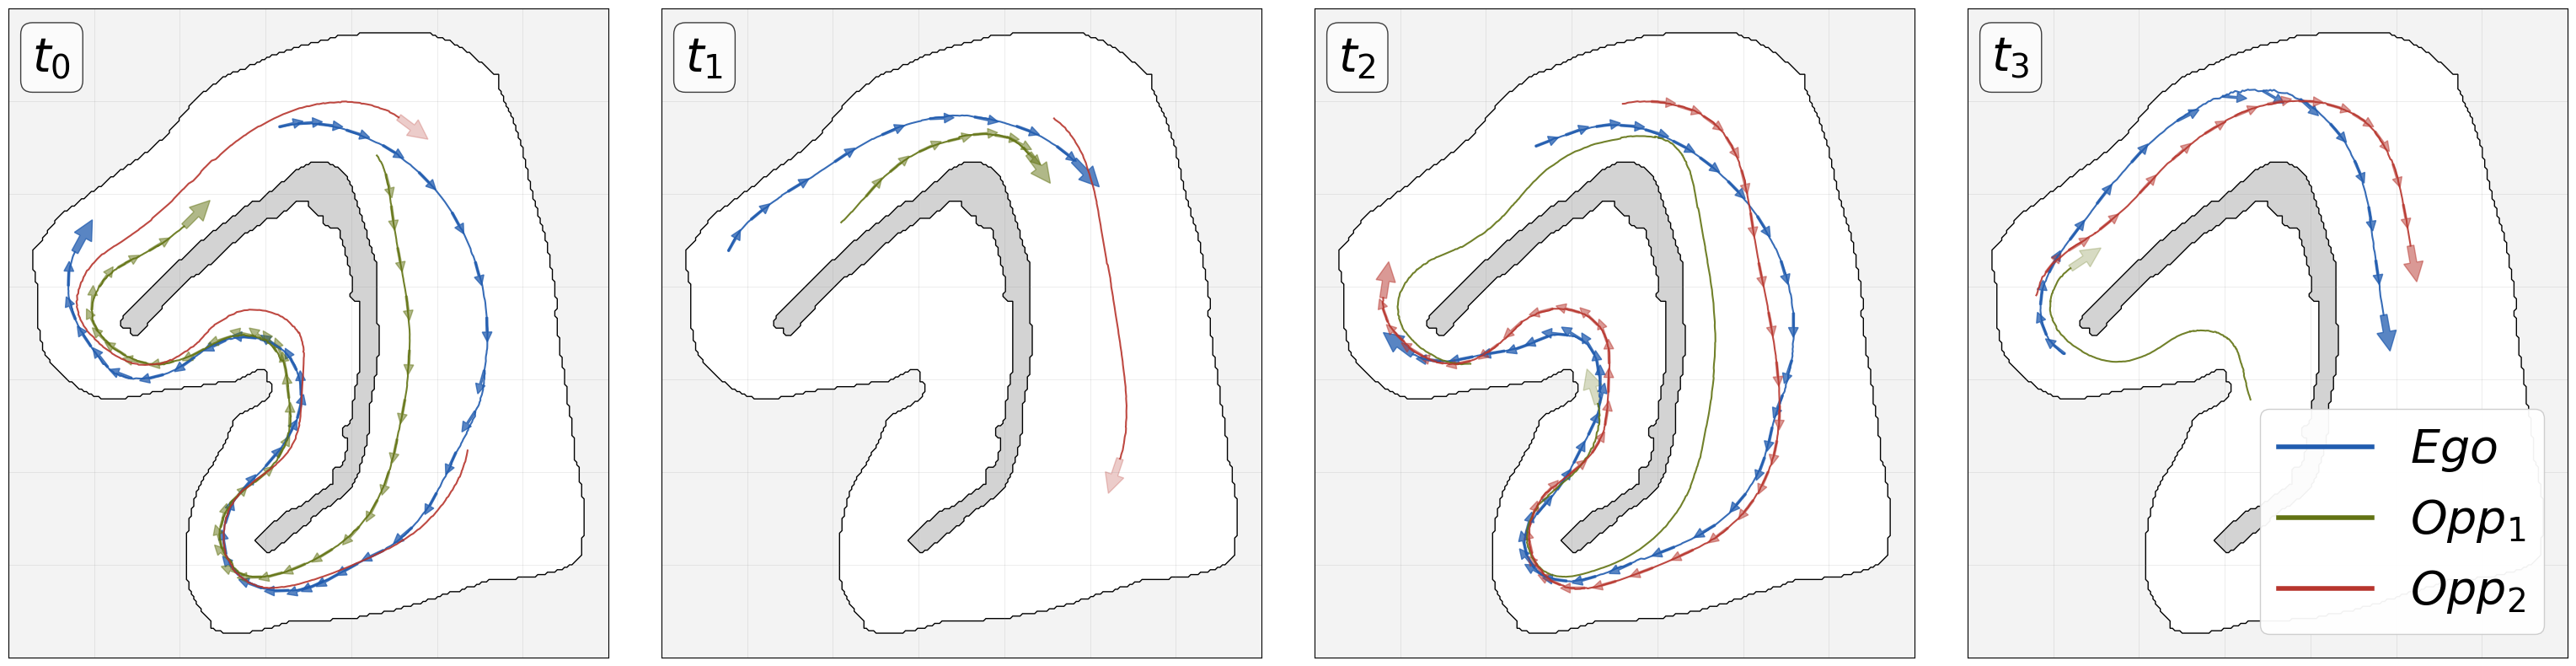

In [33]:
config = [
    {
        "polygon": True,
        "text": r'$t_0$',
        "legend": False,
    },
    {
        "polygon": True,
        "text": r'$t_1$',
        "legend": False,
    },
    {
        "polygon": True,
        "text": r'$t_2$',
        "legend": False,
    },
    {
        "polygon": True,
        "text": r'$t_3$',
        "legend": True,
    },
]



path = "/home/moe/ros_eval/plots/ot/ot_plot.pdf"
fig, axes = setup_grid(len(data), [boundary_ext.copy(), boundary_int.copy()], config=config, rotate=False)


for i in range(len(data)):
    for j in range(3):
        a = 0.25
        active = False
        if j == 0:
            id = "ego"
            active = True
            a = 0.75
        elif j == 1:
            id="opp0"
            if i <=1:
                active = True
                a = 0.5
        elif j == 2:
            id="opp1"
            if i >= 2:
                active = True
                a = 0.5
        df = pd.DataFrame()
        df["x"] = data[i][f"x_{id}"]
        df["y"] = data[i][f"y_{id}"]
        df["yaw"] = data[i][f"yaw_{id}"]
        
        axes[i] = plot_line(
            axes[i],
            df,
            colors[j],
            ""
        )
        axes[i] = plot_arrow(
            axes[i],
            df["x"].iloc[-1],
            df["y"].iloc[-1],
            df["yaw"].iloc[-1],
            color=colors[j],
            alpha=a,
            size_multiplier=2
        )
        
        if not active:
            continue
    
        
        for idx in range(0, len(df["yaw"]), YAW_EVERY):
            
            axes[i] = plot_arrow(
                axes[i],                
                df["x"].iloc[idx],
                df["y"].iloc[idx],
                df["yaw"].iloc[idx],
                color=colors[j],
                alpha=a
            )
            

handles=[]
handles.append(add_legend_entry(r'$Ego$', color=colors[0], marker="-"))
handles.append(add_legend_entry(r'$Opp_{1}$', color=colors[1], marker="-"))
handles.append(add_legend_entry(r'$Opp_{2}$', color=colors[2], marker="-"))

finish_fig(fig, path, handles, cols=1, config=config)
fig.show()

